In [37]:
import numpy as np
import time
import gymnasium as gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [38]:
#creating the gym env
env = gym.make('CartPole-v1', render_mode='rgb_array')
obs, info = env.reset(seed=42) #info contains info about the env but yaha par empty rhega in cartpole
print(obs)

[ 0.0273956  -0.00611216  0.03585979  0.0197368 ]


[ 0.02727336 -0.20172954  0.03625453  0.32351476]


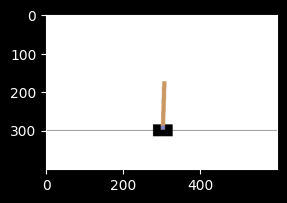

In [39]:
action=0
obs, reward, done, truncated, info = env.step(action=action)
print(obs)
img=env.render()

plt.figure(figsize=(3, 2))
plt.imshow(img)

## **This is just a simple policy to demonstrate the working In a environment**. Policy gradeint wala code niche h in which we USED NN

In [40]:
#To decide the angle and condition is self explanatory ----> This is basic policy, will try using neueral networks for gradient updates
def basic_policy(angle):
    return 0 if angle < 0 else 1

#total rewards -> jiska shape pata nahi decide krengey abhi
total = []
for episode in range(500): #running for 500 episodes
    obs, info = env.reset(seed=episode)
    episode_reward = 0
    for step in range(200): #Each episode runs for 200 steps
        action = basic_policy(obs[2])
        obs, curr_reward, done, truncated, info  = env.step(action=action)
        episode_reward += int(curr_reward)
        
        if done or truncated:
            break
    total.append(episode_reward)


print("Mean ->",np.mean(total))
print("Max ->",max(total))
print("Min ->",min(total))


Mean -> 41.698
Max -> 63
Min -> 24


# +++++++++++++++++++++++++++++++++++++++++++

## **The max reward from all 500 episode is just 63, We can improve it by using some different policy like NN ->** *Will use Pytorch to implement policy gradeint*

In [41]:
''' 
Policy Gradient methods learn stochastic policies, 
meaning the policy outputs a probability distribution over actions rather than a single deterministic action. 
This allows the agent to explore different actions and learn from their outcomes.

This happens over a entire episode, becasue the immediate reward might be intimidating but It may lead to
worse rewards later on so, considering the entire actions over an episode makes more sense.
'''

' \nPolicy Gradient methods learn stochastic policies, \nmeaning the policy outputs a probability distribution over actions rather than a single deterministic action. \nThis allows the agent to explore different actions and learn from their outcomes.\n\nThis happens over a entire episode, becasue the immediate reward might be intimidating but It may lead to\nworse rewards later on so, considering the entire actions over an episode makes more sense.\n'

In [42]:
#creating the gym env
env = gym.make('CartPole-v1', render_mode='rgb_array')
obs, info = env.reset(seed=42) #info contains info about the env but yaha par empty rhega in cartpole
print(obs)

[ 0.0273956  -0.00611216  0.03585979  0.0197368 ]


In [43]:
class Simplemodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(4,5), # 4 Input and 5 output features
            nn.ReLU(),
            nn.Linear(5,1), #5 input and just one output with sigmoid AF to classify betn take or not take action
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x) 
    
model = Simplemodel()
# print(model)
# After training we can see model parameters by ----> list(model.parameters())

In [44]:
def play_one_step(env, obs, model, loss_fn):
    obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0) # eg -> [[1,2,3,4]]
    
    left_prob = model(obs_tensor) #probability output kiya rhega betweeen 1 or 0 ---->so keep in mind and that too of going LEFT
    
    # random_value = torch.rand(1)
    action = (torch.rand(1) > left_prob).float() #typecasting -> here action is either : 0 || 1
    
    
    # if action is ZERO then : Meaning that agent should GOTO LEFT
    # the target probability of going left will be --------> y_target => 1 - 0 => 1
    
    # if action is ONE then : Meaning that agent should GOTO RIGHT
    # the target probability of going right will be -------> y_target => 1 - 1 => 0
    
    
    # y_target = torch.tensor([[1.]]) - action
    y_target = torch.ones_like(left_prob) - action
    # if(y_target >=1 or y_target <=0):
    #     print("are bhai all elements of target should be between 0 and 1")
    #     exit
    
    # loss = loss_fn(left_prob, y_target.view_as(left_prob))
    loss = loss_fn(left_prob, y_target)
    
    
    #Computing gradaeint
    model.zero_grad() #Clearing the previous gradients
    loss.backward() # Backpropagation
    
    action_int = int(action.item())
    obs, reward, done, truncated, info= env.step(action_int)
    
    
    #For each action taken, the gradients that would make the action more likely are computed (but not applied yet).
    grads = [param.grad.clone() for param in model.parameters()]
    
    return obs, reward, done, truncated, grads

# obs, r, d, t, grads = play_one_step( env, [10, 0, 5, 10], model, nn.BCELoss() )
# grads

In [45]:
# The above code was for the one step and here this is for multiple episodes
# The code here is self explanatory
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = [] # [[...],[...],[...],[...],[...],[...]]
    all_grads = []
    for episode in range(n_episodes):
        curr_rewards = []
        curr_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, rewards, done, truncated, grads = play_one_step(env,obs,model,loss_fn)
            #rewards could be [1,1,0,1,0,1,0,0,1,1,0] and only ones count like [1,1,1,1,1,1,1] untill done or truncated
            #If the pole goes more than 15.4' in either direction then we don't get reward 
            curr_rewards.append(rewards) 
            """
            grads would be:
            [ 
                1st layer W shape - [5, 4] - [[1,1,1,1],
                                              [1,1,1,1],
                                              [1,1,1,1],
                                              [1,1,1,1],
                                              [1,1,1,1]]
                ,            
                1st layer B - shape[5] - [1,1,1,1,1] each for 5 nodes
                ,
                2nd layer W - shape[1,5] - [1,1,1,1,1] -> for incoming inputs Weight
                ,
                2nd Layer B - shape[1]  - [1]
            ]
            """
            curr_grads.append(grads)     
            if done or truncated:
                break
        all_rewards.append(curr_rewards)
        all_grads.append(curr_grads)
    return all_rewards, all_grads # [[...],[...],[...],[...],[...],[...]] AND grads ka shape upar mention kiya hai :)


def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)              #[1,2,3...200]  -> Note that we are changing list to numpy array
    for step in range(len(rewards)-2, -1, -1):
        discounted[step] += discounted[step+1] * discount_factor
    return discounted                           #[1,2,3...200]

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(reward, discount_factor) for reward in all_rewards] #[[...],[...],[...],[...],[...],[...]]
    flat_rewards = np.concatenate(all_discounted_rewards)
    mean = flat_rewards.mean()
    std = flat_rewards.std()
    return [(discounted_rewards-mean)/std for discounted_rewards in all_discounted_rewards]  #[[...],[...],[...],[...],[...],[...]]
    

In [47]:
# for i, param in enumerate(model.parameters()):
# (5,4) * (4)
list(model.parameters())

[Parameter containing:
 tensor([[-0.0839, -0.4265, -0.3214, -0.3225],
         [-0.4492, -0.2552,  0.3797, -0.2291],
         [-0.1891, -0.0023, -0.2974,  0.1894],
         [-0.3604,  0.0669,  0.3275,  0.1952],
         [-0.1050, -0.4335,  0.2092,  0.0571]], requires_grad=True),
 Parameter containing:
 tensor([ 0.3825, -0.3741,  0.1919, -0.3035, -0.0323], requires_grad=True),
 Parameter containing:
 tensor([[ 0.1480,  0.3317,  0.0908, -0.3276, -0.0682]], requires_grad=True),
 Parameter containing:
 tensor([0.3411], requires_grad=True)]

# Theory

### This is how final_rewards would look like:
#### final_rewards = [
    [1, 1, 1, ..., 1],  # Episode 1 (200 steps)
    [1, 1, 1, ..., 1],  # Episode 2 (200 steps)
    [1, 1, 1, ..., 1],  # Episode 3 (200 steps)
    ...
    [1, 1, 1, ..., 1]   # Episode 10 (200 steps)
]



## policy gradeint theorem

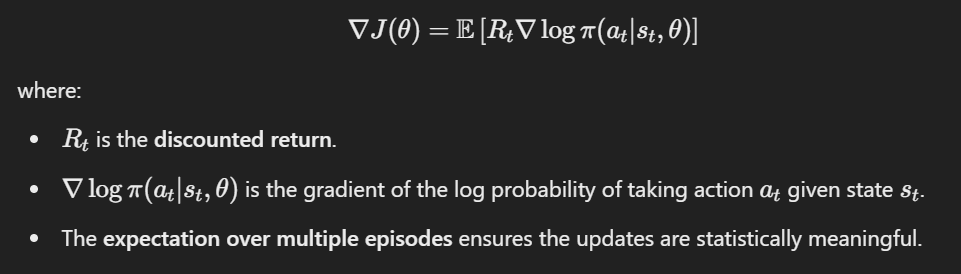

In [48]:
#Model configurations
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

optimizer = torch.optim.NAdam(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()  # Binary cross-entropy loss
# loss_fn = nn.MSELoss()  # Binary cross-entropy loss


for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(env, n_episodes_per_update, n_max_steps, model, loss_fn)

    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor) # [[...],[...],[...],[...],[...],[...]]


    #*******************************READ THIS CAREFULLY*************************
    
    all_mean_grads = [] #Exactly same as list(parameteres()) but with mean values accross 2000 steps for 10 episode
    
    #*******************************READ THIS CAREFULLY*************************
    
    #This outer loop is iterate over 4 parameters within the network -> check list(parameters())
    for var_index, param in enumerate(model.parameters()):
        #final_reward  -> a single scalar value
        #final_rewards -> contains 1 episodes ke reward i.e, 200 steps ke reward [1,2,3,....200]
        #all_final_rewards -> contains 10 episodes ke reward
        mean_grads = torch.mean(
            torch.stack([
                final_reward * all_grads[episode_index][step][var_index]
                for episode_index, final_rewards in enumerate(all_final_rewards)
                for step, final_reward in enumerate(final_rewards)
            ]),
            dim=0
        )
        all_mean_grads.append(mean_grads)

    # Apply gradients manually
    for param, mean_grad in zip(model.parameters(), all_mean_grads):
        param.grad = mean_grad  # Set gradients manually

    optimizer.step()  # Update model parameters
    optimizer.zero_grad()  # Clear accumulated gradients

In [ ]:
# for param in model.parameters():
#     print(param)
    # print()
    
    
# Fully trained model :)
list(model.parameters())

[Parameter containing:
 tensor([[ 0.1675, -0.4384, -1.9306, -1.4837],
         [-0.4565, -0.2428, -0.0332, -0.4147],
         [-0.0638,  0.4280,  1.1745,  1.2208],
         [-0.2020,  0.1531,  0.3135,  0.1471],
         [-0.0916, -0.2804,  1.7022,  1.0575]], requires_grad=True),
 Parameter containing:
 tensor([ 0.9367, -0.3845,  0.6246, -0.3754,  0.7567], requires_grad=True),
 Parameter containing:
 tensor([[ 1.1424,  0.3746, -0.9298, -0.2803, -0.8179]], requires_grad=True),
 Parameter containing:
 tensor([0.1542], requires_grad=True)]

In [115]:
def nn_policy(obs):
    obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
    prob = model(obs_tensor)
    if(prob>0.5):
        return 0
    else:
        return 1
    return int(prob)

In [118]:
# Let's test the model

def nn_policy(obs):
    obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
    prob = model(obs_tensor)
    if(prob>0.5):
        return 0
    else:
        return 1

total = []
for episode in range(500): #running for 500 episodes
    obs, info = env.reset(seed=episode)
    episode_reward = 0
    for step in range(200): #Each episode runs for 200 steps
        action = nn_policy(obs)
        obs, curr_reward, done, truncated, info  = env.step(action=action)
        episode_reward += int(curr_reward)
        
        if done or truncated:
            break
    total.append(episode_reward)
    
print("Mean ->",np.mean(total))
print("Max ->",max(total))
print("Min ->",min(total))

Mean -> 200.0
Max -> 200
Min -> 200


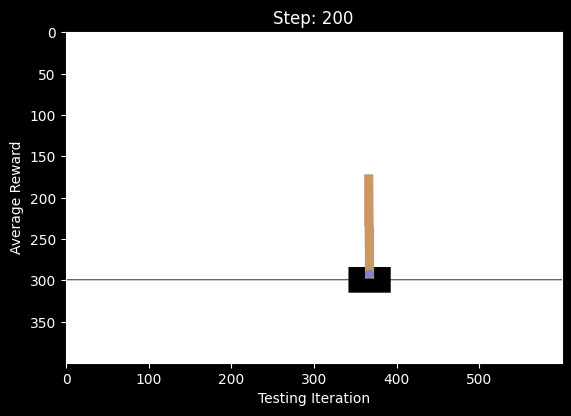

In [141]:
import matplotlib.pyplot as plt
from IPython import display

obs, info = env.reset()
img = plt.imshow(env.render())

for step in range(200+1):
    display.display(plt.gcf()) # to shows the updated plot.
    display.clear_output(wait=True) #this one clears the previous frame to create a smooth animation.
    action = nn_policy(obs)
    obs, reward, done, truncated, info = env.step(action)
    img.set_data(env.render())
    plt.xlabel('Testing Iteration')
    plt.ylabel('Average Reward')
    plt.title(f"Step: {step}")
    # plt.axis('off')
    if done or truncated:
        break